# 0. Preparation

In [1]:
import glob
import os
import random

import graphviz
import matplotlib.pyplot as plt
import nilearn.image as nimg
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import IFrame
from nilearn import plotting
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from aafm.sample_service import SampleService
from core.postprocess_service import PostprocessService
from aafm.AAFM_service import AAFMService

In [2]:
# load global vars
postproc_srv = PostprocessService()
sample_srv = SampleService()
aafm_srv = AAFMService()
basedir = "/home/ymerel/storage/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
corr_path = os.path.join(basedir, 'correlations.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

# 1. Load dataset
90 features + config hash (id) + correlation from ref + correlation from mean

In [3]:
# Mount group storage
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')

In [0]:
# write extended dataset (with mean of correlations, 10 random ref)
# Choose 10 random correlations as refs
unique_values = [value for value in correlations['source'].unique() if value not in ['ref', 'mean']]
random_refs = random.sample(list(unique_values), 10)
extended_dataset = pd.read_csv(df_path, delimiter=';')
for ref in random_refs:
    print(f"Fetching correlations for random ref [{ref}]")
    for index, row in extended_dataset.iterrows():
        id_value = row['id']
        correlation = correlations.loc[
        (correlations['source'] == id_value) &
        (correlations['target'] == ref), 'correlation'].values[0]
        extended_dataset.at[index, f'from_{ref}'] = correlation
print(f"Calculating mean of correlations for each config")
for index, row in extended_dataset.iterrows():
        id_value = row['id']
        if id_value == 'ref' or id_value == 'mean':
            continue
        values = correlations.loc[
        (correlations['source'] == id_value) & (correlations['target'] != id_value) & (correlations['target'] != 'ref') & (correlations['target'] != 'mean'), 'correlation'].values
        extended_dataset.at[index, f'mean_corr'] =  sum(values) / len(values)
# write dataset
extended_dataset.to_csv(os.path.join(basedir, 'extended_dataset.csv'), index=False, sep=';')

In [4]:
dataset = pd.read_csv(os.path.join(basedir, 'extended_dataset.csv'), delimiter=';')
corr_fields = [col for col in dataset.columns if col.startswith('from_')]
corr_fields.append('mean_corr')
dataset.head()

,spatial_smoothing/fwhm/12,spatial_smoothing/tool/spm,slice_timing_correction/ref_slice/middle,signal_modeling/hrf/temporal_dispersion_derivs,spatial_normalization/bias_fwhm/130,spatial_normalization/template,signal_modeling/hrf,signal_modeling/nuisance_regressors/motion/18,spatial_smoothing/fwhm/2,coregistration/cost_function/mutual_information,...,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6cc6ff25c55bfc81f210bb23,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746ad83ecbcc320c8fe4298a73,from_bdab21629030923da17e248d7689fc21eb1abea0d889d3b44c67b4baf6a07de5,from_6363ceb4ad5221e2fd865e8ba9181032905c33814f925c2e960adcd5354485e4,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705b65b17754f772d13f060284,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f5a612ba46b79d019b03cc46,from_c475f858fc2881ef01d1d4b705346000d23d56508ee89dcbf18e173daf48de57,from_5b935ba44056218711fe041d9e5000904a788b010f7c12dd70041a2e5cc4e135,from_05a74cdcbd5faa976b866eec5a083de5e3945cc85a8971c44863127732e7026d,mean_corr
0,False,True,False,True,False,True,True,False,True,True,...,0.583359,0.585454,0.467426,0.584460,0.640727,0.422977,0.416205,0.281066,0.813123,0.372960
1,False,True,True,False,False,True,True,False,False,False,...,0.461472,0.464436,0.624274,0.162757,0.311513,0.478202,0.595410,0.584970,0.375992,0.448391
2,False,True,True,True,False,True,True,False,True,False,...,0.046111,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453
3,True,True,False,True,False,True,True,False,False,False,...,0.357359,0.357296,0.454988,0.160300,0.258135,0.832560,0.765298,0.533354,0.457524,0.393672
4,False,True,True,True,False,True,True,True,True,False,...,0.046111,0.047896,0.054734,0.017863,0.035509,0.080146,0.109115,0.047371,0.073594,0.162453


# 2. Check features repartition
Check features repartition for all configurations vs sample

Retrieved all [27648] configurations from [/home/ymerel/fmri-feature-model/model/uvl/full_pipeline.uvl]


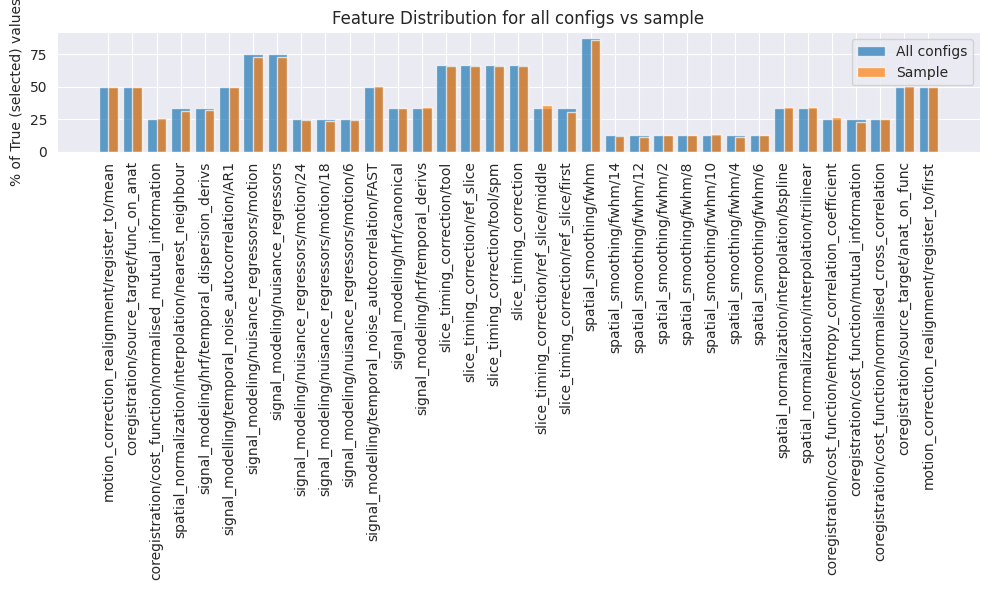

In [5]:
pd.set_option('future.no_silent_downcasting', True)
full = pd.DataFrame(sample_srv.get_all_configs()).fillna(False).astype(bool)
full_rep = full.mean() * 100
full_rep = full_rep[(full_rep > 0) & (full_rep < 100)]
ignored = corr_fields.copy()
ignored.append('id')
sample_rep = dataset.drop(columns=ignored).mean() * 100
sample_rep = sample_rep[(full_rep > 0) & (sample_rep < 100)]
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the percentages for df1
ax.bar(full_rep.index, full_rep, alpha=0.7, label='All configs')

# Plot the percentages for df2
ax.bar(sample_rep.index, sample_rep, alpha=0.7, label='Sample', align='edge', width=0.4)

# Add labels and title
ax.set_ylabel('% of True (selected) values')
ax.set_title('Feature Distribution for all configs vs sample')
ax.legend()

# Show plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Check correlations repartition

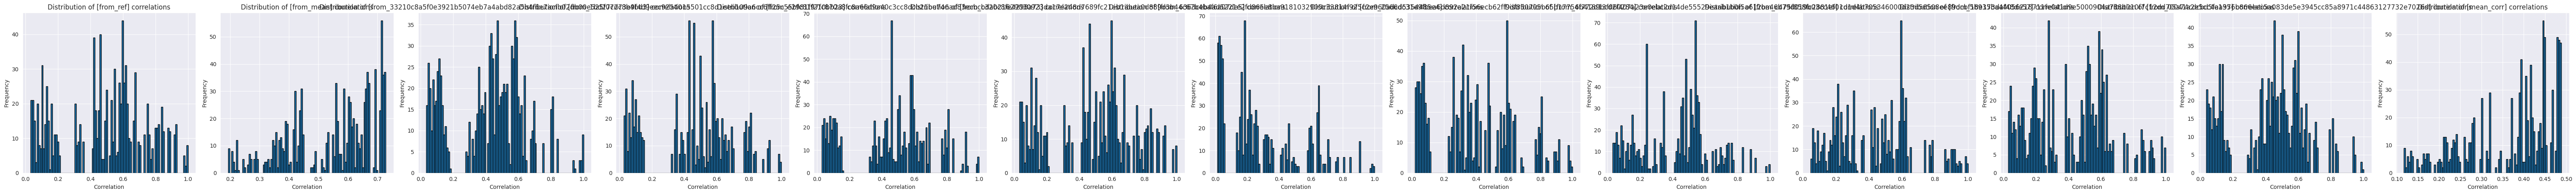

In [17]:
num_plots = len(corr_fields)
fig, axes = plt.subplots(ncols=num_plots, figsize=(5 * num_plots, 5))

for i, corr in enumerate(corr_fields):
    axes[i].hist(dataset[corr], bins=100, edgecolor='black')
    axes[i].set_title(f'Distribution of [{corr}] correlations')
    axes[i].set_xlabel('Correlation')
    axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# 4. Check stats maps
For `from_ref`, `from_mean`, `mean_corr` correlations, display the 3 "worst" and "best" correlated results

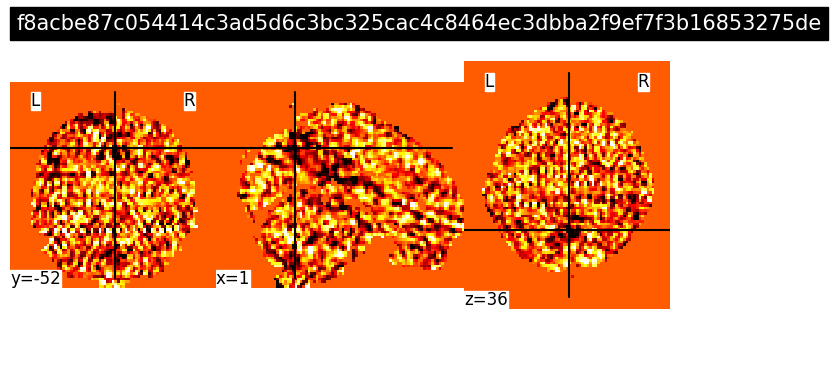

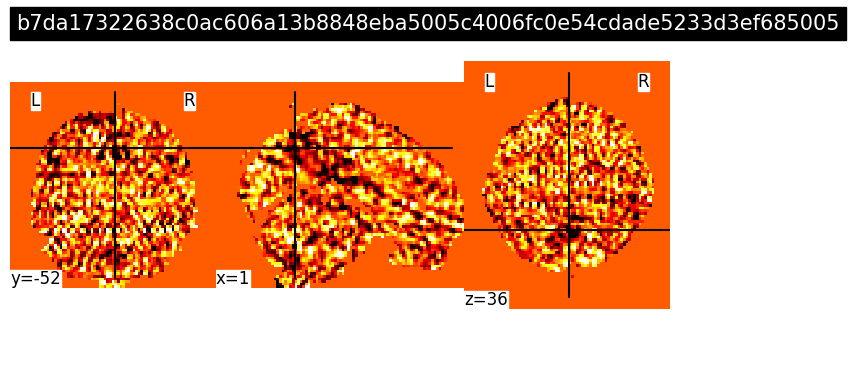

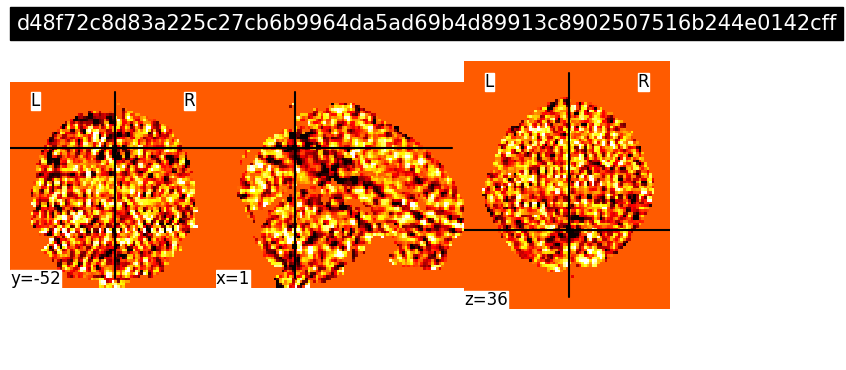

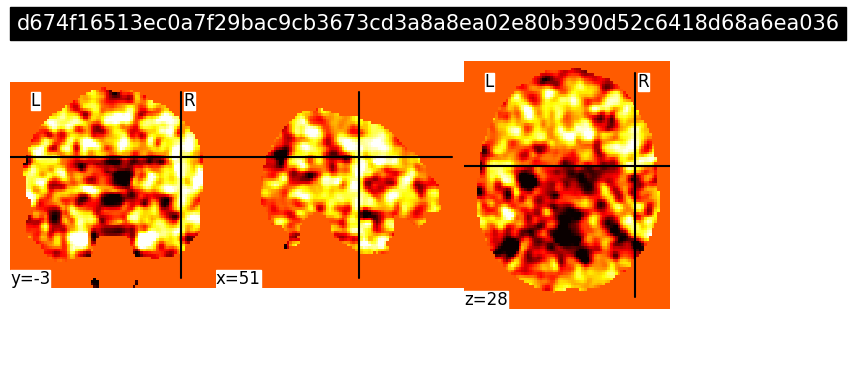

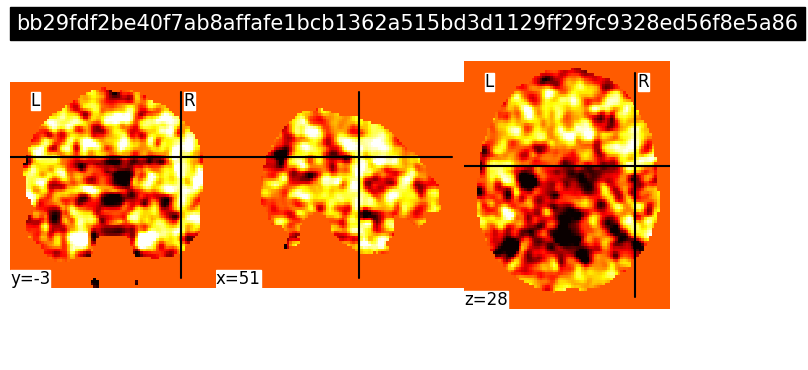

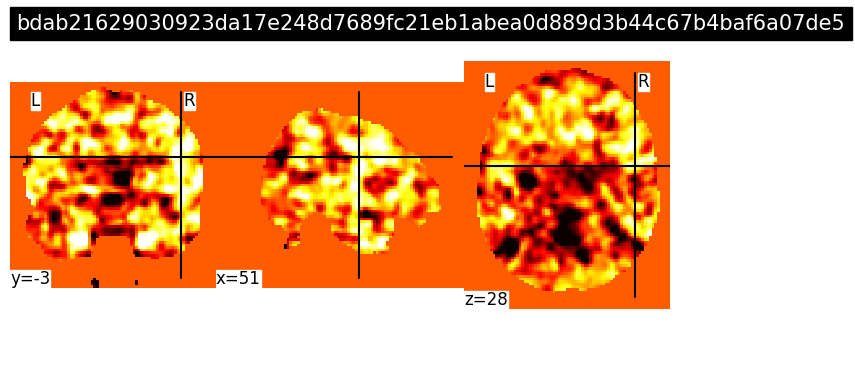

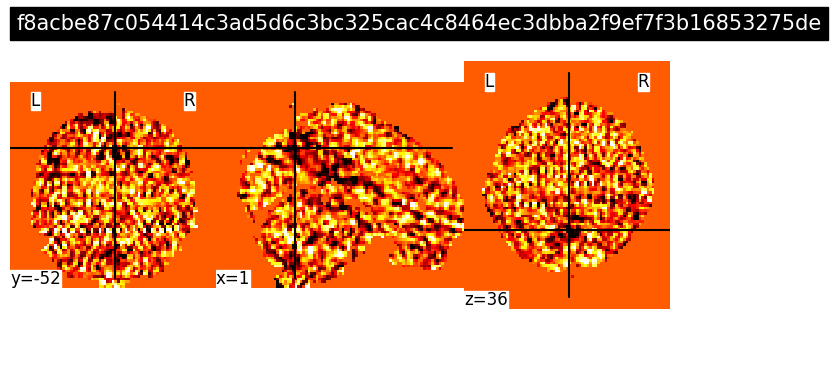

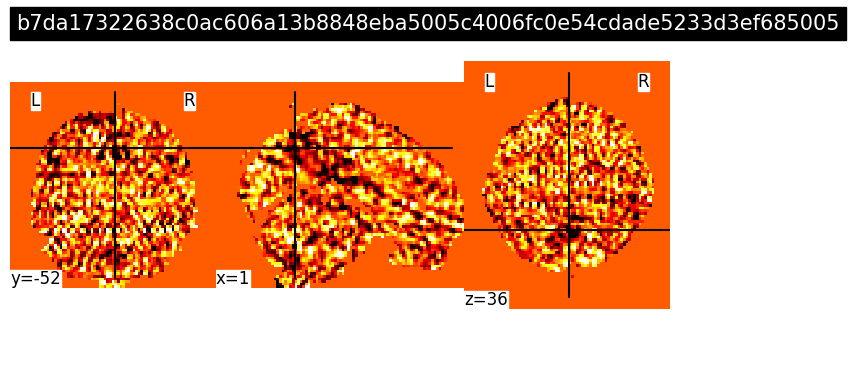

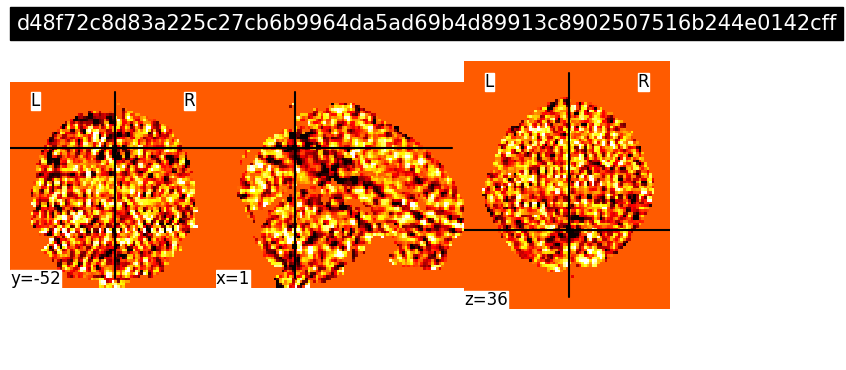

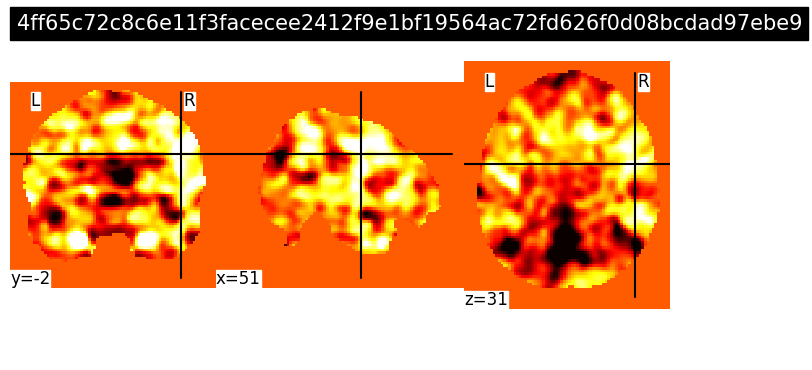

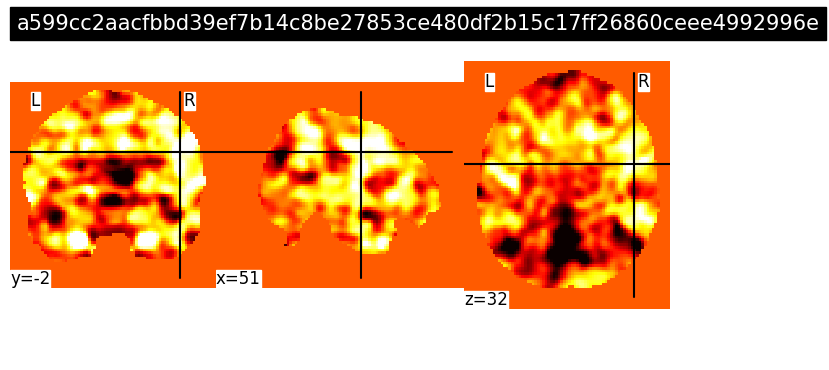

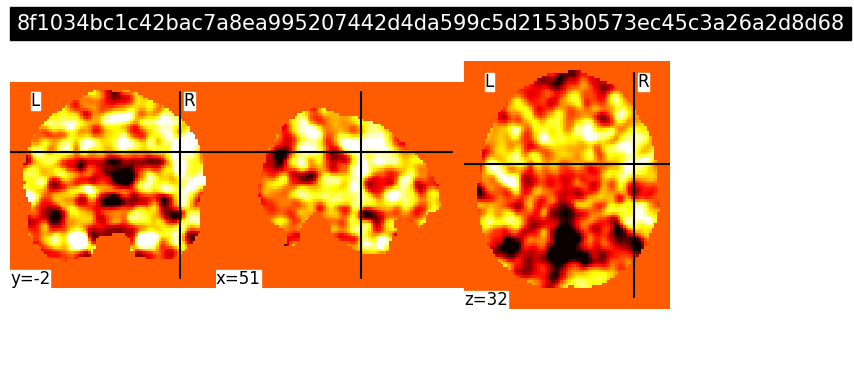

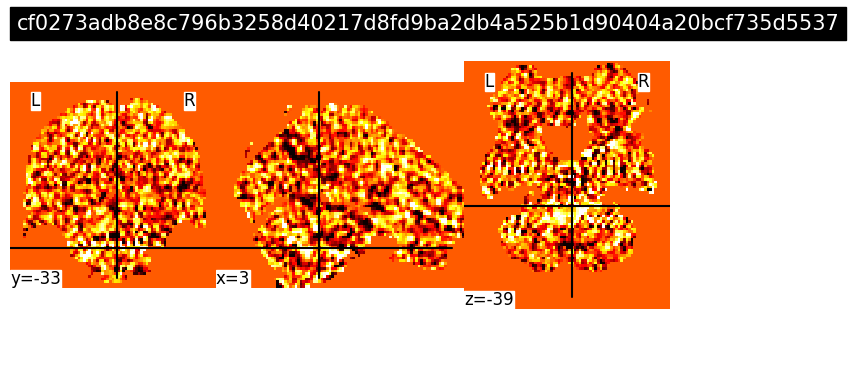

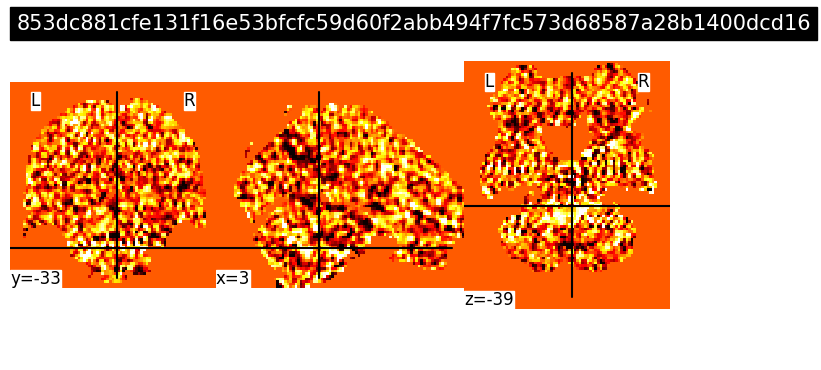

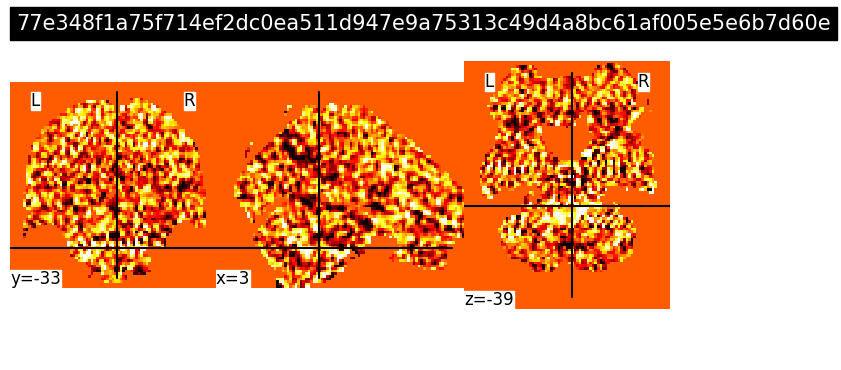

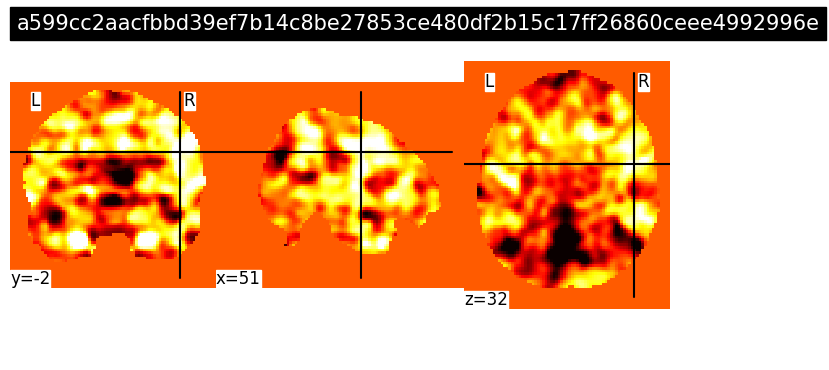

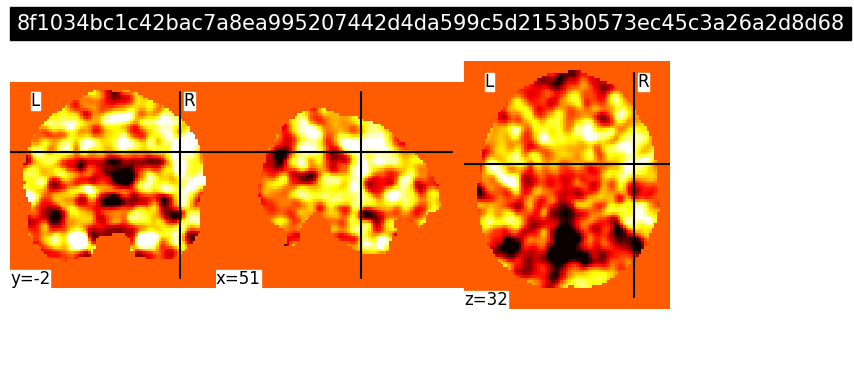

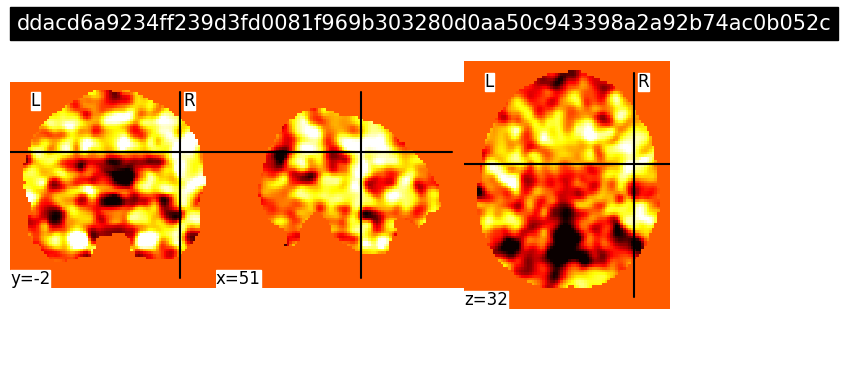

In [28]:
for ref in ['from_ref', 'from_mean', 'mean_corr']:
    corr_ids = pd.concat([dataset.nsmallest(3, ref)['id'], dataset.nlargest(3, ref)['id']])
    for conf_id in corr_ids:
        img = nimg.load_img(os.path.join(basedir, conf_id, '_subject_id_01', 'result.nii'))
        plotting.plot_img(img, title=conf_id, vmin=-2, vmax=2, cmap='hot')
plt.show()

In [42]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

errors = []
for metric in corr_fields:
    # Prepare dataset
    # ref_row = dataset[dataset['id'] == 'ref'].index
    # mean_row = dataset[dataset['id'] == 'ref'].index
    X = dataset.drop(columns=ignored)
    y = dataset[metric]
    
    test_size=0.3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    # Train model
    reg = tree.DecisionTreeRegressor(max_depth=4)
    reg.fit(X_train, y_train)
    importances = reg.feature_importances_
    features = X.columns
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    importance_df.head()
    errors.append((metric, 
                  mean_absolute_error(y_test, reg.predict(X_test)),
                  mean_squared_error(y_test,reg.predict(X_test)), 
                  mean_absolute_percentage_error(y_test, reg.predict(X_test)))
    )
errors_df = pd.DataFrame(errors, columns=['metric', 'Mean absolute error (MAE)',  'Mean squared error (MSE)', 'Mean absolute percentage error (MAPE)'])
errors_df.head(13)

,metric,Mean absolute error (MAE),Mean squared error (MSE),Mean absolute percentage error (MAPE)
0,from_ref,0.058489,0.006290,12.888662
1,from_mean,0.024018,0.000934,4.396756
2,from_33210c8a5f0e3921b5074eb7a4abd82a5b4f6e7ac...,0.046451,0.004427,11.681282
3,from_1bd27c273e9f4d9eec9254015501cc8d1eeb109a6...,0.067094,0.007773,16.435477
4,from_e2981f97fc870a8fc8a66d9a40c3cc8dcb21be746...,0.065964,0.008037,14.927462
5,from_bdab21629030923da17e248d7689fc21eb1abea0d...,0.055102,0.005975,12.973953
6,from_6363ceb4ad5221e2fd865e8ba9181032905c33814...,0.040890,0.003263,16.983211
7,from_2566dc31e9fbea6d892a21f56ecb62ff9df850705...,0.058240,0.006383,17.955552
8,from_6b4189bcd2f407a23e0ebc2d14de55529eaab1b0f...,0.031657,0.002217,8.556464
9,from_c475f858fc2881ef01d1d4b705346000d23d56508...,0.048940,0.004397,12.715864


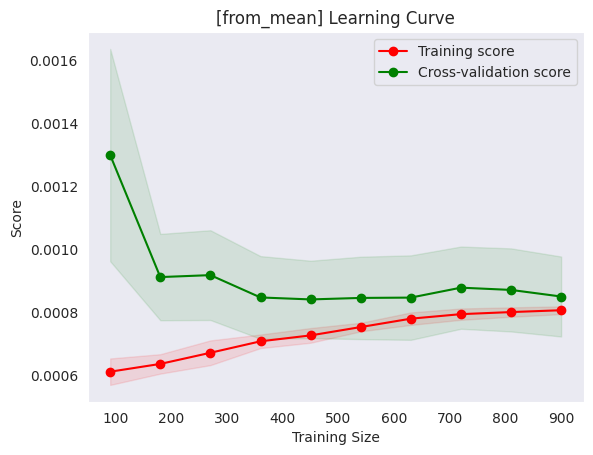

In [21]:
# learning curve
# Define the range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    reg, X, y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, -train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, -test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.1, color='g')
plt.grid()
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title(f'[{metric}] Learning Curve')
plt.legend(loc='best')
plt.show()

In [22]:
# Display tree
def print_tree(clf, f_names, name):
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=f_names,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(name)
    
print_tree(reg, X_train.columns.values, f"tree_{metric}")

filepath = f"tree_{metric}.pdf"
IFrame(filepath, width=700, height=500)

In [6]:
correlations = pd.read_csv(corr_path, delimiter=';')
correlations.head()

,source,target,correlation
0,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,0a3e49ee189809ec52afbdb3c3c5083f090dcb0d218326...,1.0
1,5c20760d37a8aa728efbbec6efc518da72c638cc88cdcd...,27682e60e19461bb32135219bee090029916238dfaf2f0...,1.0
2,3097a7dc41788499cf25575641e12f92017eaec464039b...,3d1d19d1d409196d5fa1185e4aa24f30701dd6cc448a06...,1.0
3,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,bbb3beabd28e8a1d0f553be543e76a38246c1416fbfb00...,1.0
4,63bea197905677a189c165af71c8fc3933529cfb732832...,3097a7dc41788499cf25575641e12f92017eaec464039b...,1.0


/home/ymerel/fmri-feature-model/.venv/lib64/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/ymerel/fmri-feature-model/.venv/lib64/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 2000x2000 with 0 Axes>

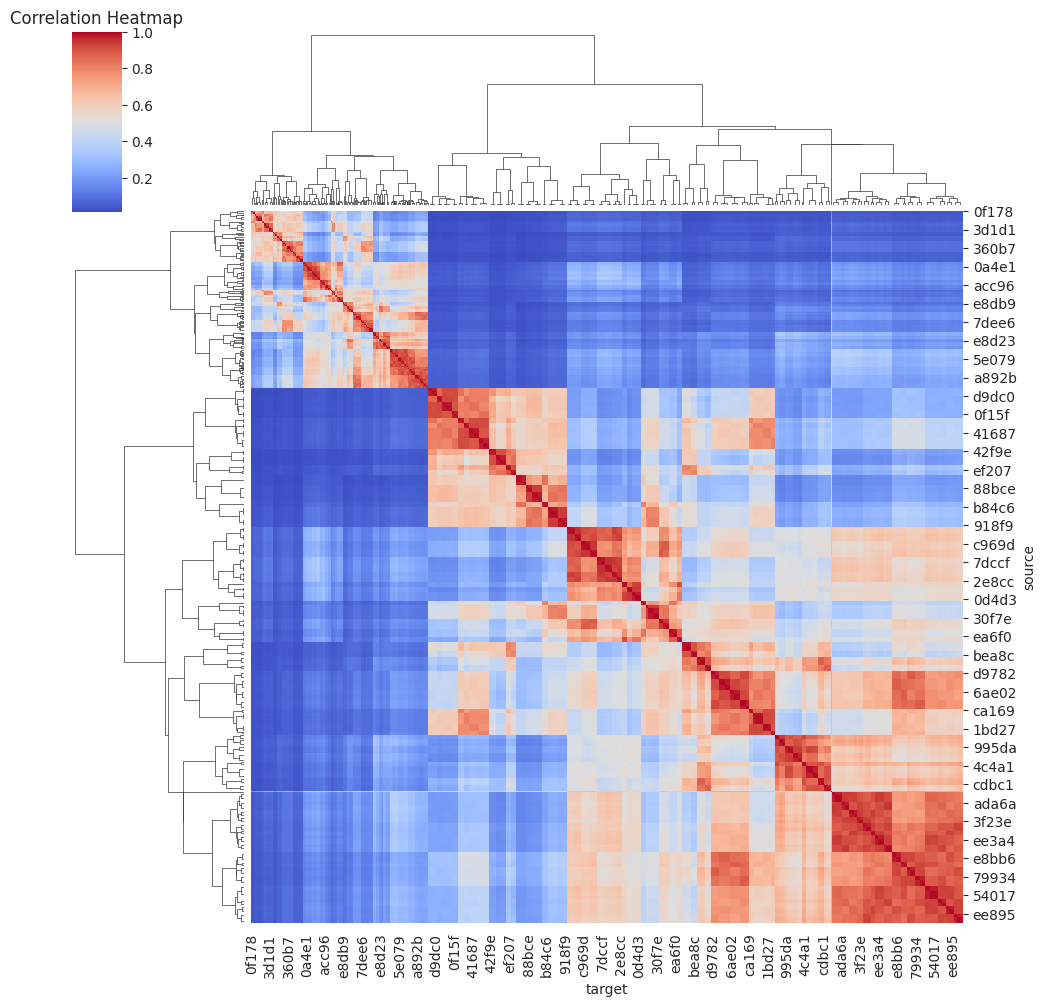

In [7]:
correlations['source'] = correlations['source'].str.slice(0, 5)
correlations['target'] = correlations['target'].str.slice(0, 5)
data = correlations.pivot(index='source', columns='target', values='correlation').fillna(1.0)
plt.figure(figsize=(20, 20))
sb.clustermap(data, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
